# Preprocessing and Modeling

---
### Objective
This notebook aims to use natural language processing (NLP) techniques to preprocess the large collection of subreddit posts and impliment multiple classification models to produce the highest level of accuracy. The posts are first lemmatized to create more indicative tokens, then vectorized using three different methods: count, TF-IDF, and hashing. Using pipelines and gridsearch to tune hyperparameters, the data is classified through six different models to determine the best one.

---
#### External Libraries Import

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pactools.grid_search import GridSearchCVProgressBar
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Read in the Data

In [4]:
buddha = pd.read_csv('./Datasets/buddhism_subreddit.csv')
tao = pd.read_csv('./Datasets/taoism_subreddit.csv')

### Create Corpus of Reddit Posts

In [5]:
dfs = [buddha , tao]
corpus = pd.concat(dfs, ignore_index = True)

#### Handle Empty Posts

In [6]:
# combine 'title' with 'selftext' and create a new column
# this code fills nan values (pictures, links, etc) with the title

corpus['selftext'].fillna('' , inplace =True)
corpus['text'] = corpus['title'] + ' ' + corpus['selftext']

### Observe Word Frequencies Through Count Vectorization

In [7]:
# create custom stop words
custom_stop_words = list(ENGLISH_STOP_WORDS)
custom_stop_words.extend(('like' , 'just' , 'http'))

# count vectorize the posts with words as tokens
vect = CountVectorizer(stop_words = custom_stop_words)
X_vect = vect.fit_transform(corpus['text'])
text = pd.DataFrame(X_vect.toarray(), columns=vect.get_feature_names())
text.index = corpus['subreddit']

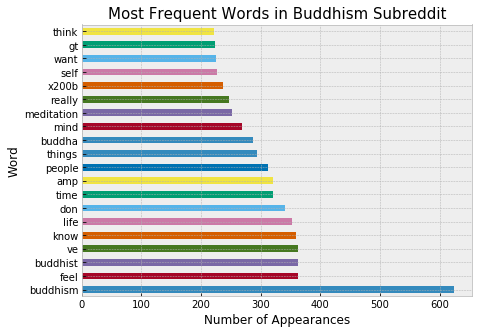

In [8]:
plt.style.use('bmh')
# plot top 20 frequent words in Buddhism subreddit
plt.figure(figsize = (7 , 5))
zen_mask = text.index == 'Buddhism'
text[zen_mask].sum().sort_values(ascending = False)[:20].plot(kind = 'barh')
plt.title('Most Frequent Words in Buddhism Subreddit' , fontsize = 15)
plt.xlabel('Number of Appearances' , fontsize = 12)
plt.ylabel('Word' , fontsize = 12);

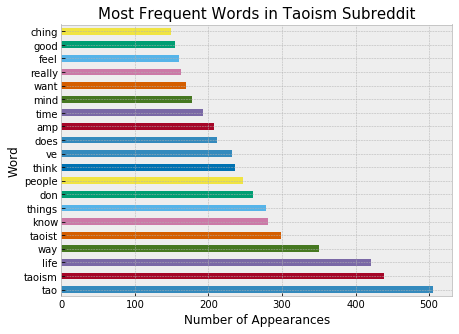

In [9]:
# plot top 20 frequent words in Taoism subreddit
plt.figure(figsize = (7 , 5))
tao_mask = text.index == 'taoism'
text[tao_mask].sum().sort_values(ascending = False)[:20].plot(kind = 'barh')
plt.title('Most Frequent Words in Taoism Subreddit' , fontsize = 15)
plt.xlabel('Number of Appearances' , fontsize = 12)
plt.ylabel('Word' , fontsize = 12);

These plots display the words that occur most frequently in each subreddit. Words like Tao, Taoism, Buddhism, and Buddhist are obviously at the top. Some of the other words are interesting to oberve to understand the common tone of posts within the subreddits.

### Lemmatization

In [10]:
# lemmatize the posts to group words with same meaning into same token
# this also gets rid of unwanted characters

# tokenize using words as tokens
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

lem_text = []
for x in corpus['text']:
    tokens = tokenizer.tokenize(x)
    z=[lemmatizer.lemmatize(word) for word in tokens]
    z=' '.join(z)
    lem_text.append(z)
corpus['lemmatized_text'] = lem_text

### Train/Test Split the Data

In [11]:
X = corpus['lemmatized_text']
y = corpus['subreddit']

# stratify y to balance classes in both train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 77, 
                                                    stratify = y)

## Logistic Regression Pipeline with Different Vectorization Methods

#### Count Vectorization

In [12]:
# create a pipeline using CountVectorizer

steps_vc = [('vect', CountVectorizer()),('lr' , LogisticRegressionCV())]

pipe_vc = Pipeline(steps = steps_vc)

In [13]:
# tune hyperparameters using GridSearchCV

vclr_params = {
    'vect__max_features': [30000, 50000],
    'vect__stop_words': [None , 'english'],
    'vect__ngram_range': [(1,1), (1,2)],
    'lr__Cs': [1 , 10]
}
gs_vc = GridSearchCVProgressBar(pipe_vc, param_grid = vclr_params)
gs_vc.fit(X_train , y_train)
print(gs_vc.best_score_)
print(gs_vc.best_params_)

[........................................] 100% | 162.59 sec | GridSearchCV 
0.8765182186234818
{'lr__Cs': 10, 'vect__max_features': 30000, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}


In [14]:
# check model score on testing dataset

print(f'Test data produced an accuracy score of {gs_vc.score(X_test , y_test)}')

Test data produced an accuracy score of 0.9210526315789473


#### Term Frequency-Inverse Document Frequency Vectorization

In [40]:
steps_tf = [('tf', TfidfVectorizer()),('lr' , LogisticRegressionCV())]

pipe_tf = Pipeline(steps = steps_tf)

In [41]:
tflr_params = {
    'tf__max_features': [30000 , 50000],
    'tf__ngram_range': [(1,1), (1,2)],
    'tf__stop_words': [None, 'english'],
    'lr__Cs': [1 , 10]
}
gs_tf = GridSearchCVProgressBar(pipe_tf, param_grid = tflr_params)
gs_tf.fit(X_train , y_train)
print(gs_tf.best_score_)
print(gs_tf.best_params_)

[........................................] 100% | 88.63 sec | GridSearchCV 
0.888663967611336
{'lr__Cs': 10, 'tf__max_features': 50000, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}


In [42]:
print(f'Test data produced an accuracy score of {gs_tf.score(X_test , y_test)}')

Test data produced an accuracy score of 0.9251012145748988


#### Hashing Vectorization

In [18]:
steps_hf = [('hf', HashingVectorizer()),('lr' , LogisticRegressionCV())]

pipe_hf = Pipeline(steps = steps_hf)

In [19]:
hflr_params = {
    'hf__n_features': [30000, 50000],
    'hf__ngram_range': [(1,1), (1,2)],
    'hf__stop_words': [None, 'english'],
    'lr__Cs': [1 , 10]
}
gs_hf = GridSearchCVProgressBar(pipe_hf, param_grid = hflr_params)
gs_hf.fit(X_train , y_train)
print(gs_hf.best_score_)
print(gs_hf.best_params_)

[........................................] 100% | 130.22 sec | GridSearchCV 
0.8765182186234818
{'hf__n_features': 30000, 'hf__ngram_range': (1, 1), 'hf__stop_words': 'english', 'lr__Cs': 10}


In [20]:
print(f'Test data produced an accuracy score of {gs_hf.score(X_test , y_test)}')

Test data produced an accuracy score of 0.9048582995951417


#### Save Data for Best Logistic Regression Model

In [43]:
# TF-IDF produced best score for testing set so saved the info into package for future interpretation
lrdata_dict = {'X_train': X_train,
             'X_test': X_test,
             'y_train': y_train,
             'y_test': y_test,
             'lr_pack': gs_tf}

pickle.dump(lrdata_dict, open('./Best_Models/lr_package.pk', 'wb'))

#### Takeaways

The logistic regression using TF-IDF produced the highest score among the three vectorization methods. Logistic regression coefficients are easily interpretable so are saved for further analysis.

## Random Forest Pipeline with Different Vectorization Methods

#### Count Vectorization

In [28]:
steps_vc = [('vect', CountVectorizer()),('rf' , RandomForestClassifier())]

pipe_vc = Pipeline(steps = steps_vc)

In [29]:
vcrf_params = {
    'vect__max_features': [10000, 30000],
    'vect__stop_words': [None , 'english'],
    'vect__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [150, 200, 250],
    'rf__max_depth': [None, 1, 2]
}
gs_vcrf = GridSearchCVProgressBar(pipe_vc, param_grid = vcrf_params)
gs_vcrf.fit(X_train , y_train)
print(gs_vcrf.best_score_)
print(gs_vcrf.best_params_)

[........................................] 100% | 308.23 sec | GridSearchCV 
0.8670715249662618
{'rf__max_depth': None, 'rf__n_estimators': 200, 'vect__max_features': 30000, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}


In [31]:
# check score with test
print(f'Test data produced an accuracy score of {gs_vcrf.score(X_test , y_test)}')

Test data produced an accuracy score of 0.8704453441295547


#### Term Frequency-Inverse Document Frequency Vectorization

In [36]:
steps_tf = [('tf', TfidfVectorizer()),('rf' , RandomForestClassifier())]

pipe_tf = Pipeline(steps = steps_tf)

In [37]:
tfrf_params = {    
    'tf__max_features': [10000, 30000],
    'tf__stop_words': [None , 'english'],
    'tf__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [150, 200, 250],
    'rf__max_depth': [None, 1, 2]
}
gs_tfrf = GridSearchCVProgressBar(pipe_tf, param_grid = tfrf_params)
gs_tfrf.fit(X_train , y_train)
print(gs_tfrf.best_score_)
print(gs_tfrf.best_params_)

[........................................] 100% | 311.26 sec | GridSearchCV 
0.8630229419703104
{'rf__max_depth': None, 'rf__n_estimators': 200, 'tf__max_features': 30000, 'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}


In [39]:
print(f'Test data produced an accuracy score of {gs_tfrf.score(X_test , y_test)}')

Test data produced an accuracy score of 0.8724696356275303


#### Hashing Vectorization

In [44]:
steps_hf = [('hf', HashingVectorizer()),('rf' , RandomForestClassifier())]

pipe_hf = Pipeline(steps = steps_hf)

In [45]:
hfrf_params = {    
    'hf__n_features': [10000, 30000],
    'hf__ngram_range': [(1,1), (1,2)],
    'hf__stop_words': [None, 'english'],
    'rf__n_estimators': [150, 200, 250],
    'rf__max_depth': [None, 1, 2]
}
gs_hfrf = GridSearchCVProgressBar(pipe_hf, param_grid = hfrf_params)
gs_hfrf.fit(X_train , y_train)
print(gs_hfrf.best_score_)
print(gs_hfrf.best_params_)

[........................................] 100% | 345.11 sec | GridSearchCV 
0.8589743589743589
{'hf__n_features': 10000, 'hf__ngram_range': (1, 1), 'hf__stop_words': 'english', 'rf__max_depth': None, 'rf__n_estimators': 150}


In [46]:
print(f'Test data produced an accuracy score of {gs_hfrf.score(X_test , y_test)}')

Test data produced an accuracy score of 0.8825910931174089


#### Takeaways

Among the three random forests, the hashing vectorization method correctly classified the most in the testing dataset. Because of the low interpretability of hashing vectorization, the TF-IDF method is saved for further interpetation.

In [51]:
# each model produced similar results so saved the TF-IDF model for further interpretation
tfdata_dict = {'X_train': X_train,
             'X_test': X_test,
             'y_train': y_train,
             'y_test': y_test,
             'rf_pack': gs_tfrf}

pickle.dump(tfdata_dict, open('./Best_Models/rf_package.pk', 'wb'))

### Model Comparison

Deciding on the "best" model boils down to explanatory power (R-squared), interpretability, and the bias-variance tradeoff. While every model was slightly underfit, indicating bias, none of the them were underfit enough to cause concern. The model with the most predictive power is the logistic regression combined with the TF-IDF vectorization method. It correctly classified 92.5% of the posts in the test data set. Because of the interpretability of logistic regression coefficients, this model is considered "best". When comparing logistic regression to random forest, the logistic regressions performed better for every type of vectorization method by a margin of around 4%.